In [1]:
# Transfer Learning(전이학습)
# Transfer Learning(전이학습)이란 아주 큰 데이터셋, 즉 21,841 부류에 대해서 총 1419만7122장의 이미지로 구성되어 있는
# ImageNet 데이터를 사용해서 학습된 모델의 가중치를 가져와서, 우리가 해결하려는 문제에 맞게 보정해서 사용하는 것을 의미함
# 이때 큰 데이터셋을 사용해서 훈련된 모델을 사전학습모델(pre-trained model)이라고 함
# ImageNet 데이터의 이미지 크기는 평균적으로 469x387 이며, 이러한 2만개 이상의 부류 가운데 1000 부류만 뽑아서 데이터를 구성하고
# 정확도를 높이는 대회가 바로 ImageNet Challenge 이다

# 전이학습 필요성 
# ImageNet(풍부한 데이터) -> 사전학습모델(pre-trained model) -> 전이학습(Transfer Learning) -> 새롭게 학습되는 모델(일반적으로 파인튜닝으로 사용됨) <- 부족한 사용자 데이터

# 사전 학습 모델 구조(pre-trained model)
# 입력 -> 사전 학습된 특징 추출기(pre-trained feature extractor) -> 사전 학습된 분류기(pre-trained classifier) -> 출력

# 사전 학습된 특징 추출기(pre-trained feature extractor)
# - 특징 추출기(feature extractor)는 컨볼루션층과 풀링층의 조합으로 구성되어 있으며, ImageNet 데이터에 대해 이미 학습되어 있음
# - conv->conv->pooling->, 특징 추출기는 출력 데이터를 bottleneck 또는 feature vector 등으로 지칭함

# 사전 학습된 분류기(pre-trained classifier)
# - 분류기(classifier)는 완전 연결층으로 구성되며 추출된 특징을 입력으로 받아 최종적으로 주어진 이미지에 대한 클래스(정답)을 카테고리 형태로 분류하는 역할 수행
# - Linear->Linear->Linear(Softmax)->, 오버피팅을 줄이기 위해 출력층 이전의 Linear layer 사이에는 Dropout, BatchNormalization layer 등을 추가 할 수 있음

# 파인 튜닝(Fine Tuning)
# - 사전 학습 모델의 가중치를 미세하게 조정하는 기법이며, 새롭게 분류하려는 데이터의 종류와 전체 개수를 미리 분석한 후에, 
#   그것을 바탕으로 사전 학습 모델 가중치 일부만을 재학습 시키거나 또는 모든 가중치를 처음부터 다시 학습시킬 수 있음

In [2]:
# import, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets # 다양한 사전 학습 모델을 포함한 모듈
from torch.utils.data import Dataset, DataLoader, random_split
import os, shutil, zipfile
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# dog_image dataset 데이터 다운로드
# dog_image.zip

In [7]:
# 데이터 폴더 존재시 삭제
if os.path.exists('.\\data\\pytorch_dog_image'):
    shutil.rmtree('.\\data\\pytorch_dog_image')
    print('.\\data\\pytorch_dog_image is removed')

In [8]:
# 압축풀기
with zipfile.ZipFile('.\\data\\pytorch_dog_image.zip', 'r') as target_file:
    target_file.extractall(os.path.join('.\\data', 'dog_image'))

In [9]:
# 경로 설정
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'dog_image')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [12]:
# 데이터 개수 확인

label_name_list = os.listdir(os.path.join('.\\data', 'dog_image\\train'))
print('total label nums = ', len(label_name_list))
print(label_name_list)

total label nums =  4
['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']


In [14]:
# 이미지 보강

# train
train_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.RandomHorizontalFlip(), # 이미지 좌우반전 50% 효과
                                   transforms.ToTensor() # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                 ])
# validation
validation_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor() # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                 ])
# test
test_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor() # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                 ])

In [15]:
# 이미지 데이셋 생성

# train dataset
train_dataset = datasets.ImageFolder(root='.\\data\\dog_image\\train',
                                     transform=train_config)
# validation dataset
validation_dataset = datasets.ImageFolder(root='.\\data\\dog_image\\validation',
                                     transform=validation_config)
# test dataset
test_dataset = datasets.ImageFolder(root='.\\data\\dog_image\\test',
                                     transform=test_config)


In [16]:
# Batch, DataLoader 생성

BATCH_SIZE = 32

# train
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)
# validation
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)
# test
test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'chihuahua', 1: 'jindo_dog', 2: 'shepherd', 3: 'yorkshire_terrier'}


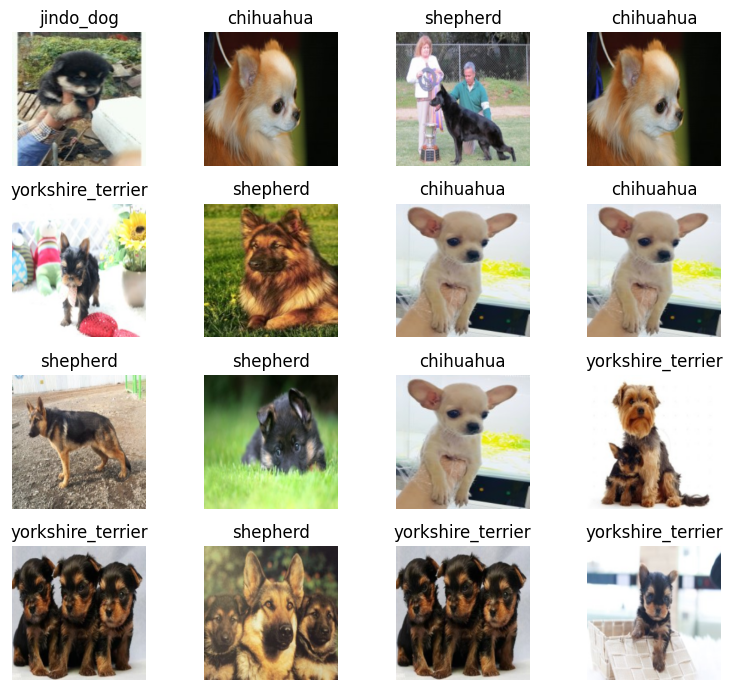

In [17]:
# 1개 배치 추출
images, labels = next(iter(train_dataset_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
# pre-trained model(사전학습모델) ViT(Vision Transfomer) 다운로드
# ViT 특징 추출기(Transfomer Encoder) -> ViT 원본 분류기 Clssifier(MLP Head)
# 적용 사례 : Cats and Dogs 데이터셋 학습데이터 2,000, 테스트데이터 1,000 - 절대적인 데이터 개수가 부족함
# 사전 학습 모델 vit_b_16(), 사전 학습된 가중치 weights=models.ViT_B_16_Weights.DEFAULT
pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
print(pretrained_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Transfer Learning Model
class TransferLearningModel(nn.Module):
    def __init__(self, pretrained_model, feature_extractor):
        super().__init__()

        # feature_extractor == True 면 feature_extractor 의 parameter 값을 업데이트 하지 않고 그대로 사용한다고해서 , parameter 를 동결(freeze) 시킨다는 표현을 많이 사용
        if(feature_extractor):
            for param in pretrained_model.parameters():
                param.requires_grad = False # 특정 파라미터의 기울기 계산을 중단시키는 설정, 가중치/바이어스 학습과정에서 업데이트 되지 않음
        
        # 학습데이터에 맞게 새로운 분류기를 만들어 준 후에, 기존 사전학습모델 classifier 부분을 새로운 classifier 로 반드시 바꾸어야 함
        pretrained_model.heads = nn.Sequential(
            nn.Linear(pretrained_model.heads[0].in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 4) # 4종 강아지 분류(classification)
        )
        self.model = pretrained_model
    
    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
feature_extractor = False # True : feature_extractor, False : Fine Tuning

# model 객체 생성
model = TransferLearningModel(pretrained_model, feature_extractor).to(DEVICE)
# loss function
loss_function = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [26]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [27]:
# Model evaluate 함수
def model_evaluate(dataloader, model, loss_function, optimizer):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [28]:
# Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [29]:
# Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 40

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  1.383036 , train acc =  26.003344 val loss =  1.368607 , val acc =  25.791855
epoch :  02 train loss =  1.364274 , train acc =  30.434783 val loss =  1.352773 , val acc =  28.506787
epoch :  03 train loss =  1.348508 , train acc =  34.531773 val loss =  1.336000 , val acc =  39.819005
epoch :  04 train loss =  1.335973 , train acc =  37.123746 val loss =  1.317128 , val acc =  47.963801
epoch :  05 train loss =  1.317087 , train acc =  42.140468 val loss =  1.295349 , val acc =  62.443439
epoch :  06 train loss =  1.295116 , train acc =  47.240803 val loss =  1.271543 , val acc =  67.873303
epoch :  07 train loss =  1.273495 , train acc =  50.668896 val loss =  1.242979 , val acc =  75.113122
epoch :  08 train loss =  1.251552 , train acc =  55.852843 val loss =  1.212487 , val acc =  80.995475
epoch :  09 train loss =  1.218707 , train acc =  58.695652 val loss =  1.179777 , val acc =  86.877828
epoch :  10 train loss =  1.184143 , train acc =  64.297659 val 

In [30]:
# 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, 
           model=model)

accuracy =  95.23809523809524 , loss =  0.4532688558101654


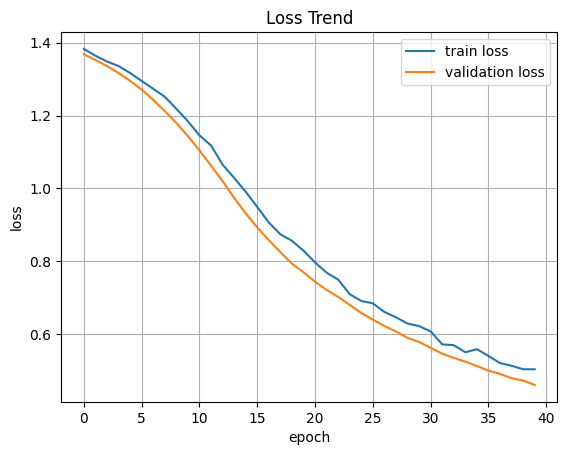

In [31]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

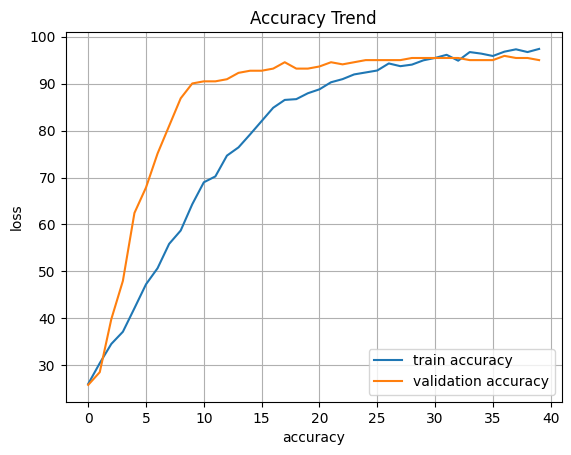

In [32]:
# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [33]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_transfer_learning_dog_image.ckpt')

In [36]:
# 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, 
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# PC 메모리 리소스의 한계때문에 배치사이즈 32로 제한하여 추출
test_images, test_labels = next(iter(test_image_loader))

x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

{0: 'chihuahua', 1: 'jindo_dog', 2: 'shepherd', 3: 'yorkshire_terrier'}


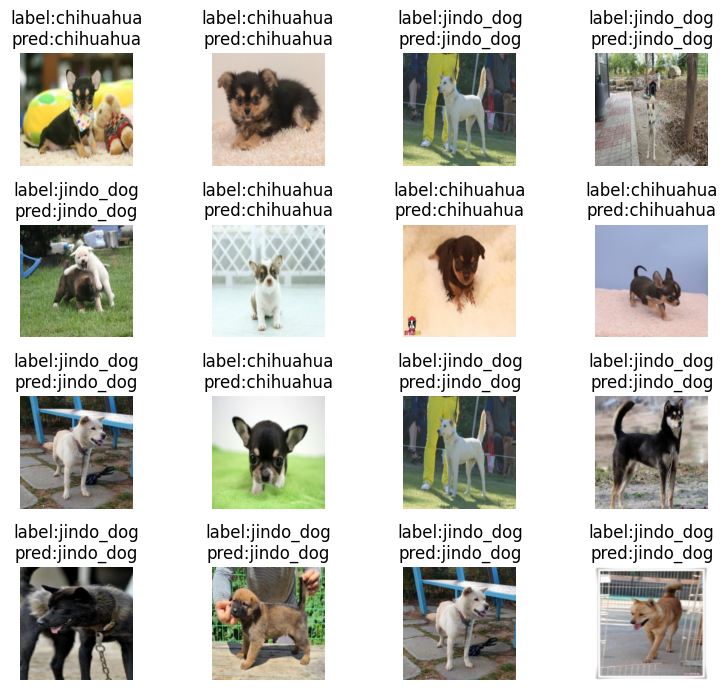

In [51]:
# 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()